In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [ ]:
def get_comparable_time_series_df(*time_series_dfs):
    """
    Takes as input a series of pandas DataFrames with different sizes and NaN values,
    and returns a DataFrame with comparable time series (same size, same dates, and without NaNs).

    Parameters:
    *time_series_dfs (pd.DataFrame): Series of pandas DataFrames with two columns (dates and values).

    Returns:
    pd.DataFrame: DataFrame with comparable time series.
    """

    # Verify if the time series are all of type pd.DataFrame
    for i, df in enumerate(time_series_dfs):
        if not isinstance(df, pd.DataFrame):
            raise ValueError(f"The input {i+1} is not a pd.DataFrame type")
        if df.shape[1] != 2:
            raise ValueError(f"The input {i+1} does not have 2 columns")


    # Extract the time series from the DataFrames without modifying the original inputs
    time_series_dict = {}
    for i, df in enumerate(time_series_dfs):
        df_copy = df.copy()
        date_col = df_copy.columns[0]
        price_col = df_copy.columns[1]
        df_copy.set_index(date_col, inplace=True)
        time_series_dict[price_col] = df_copy[price_col]

    # Find the intersection of common dates among all time series
    common_dates = list(time_series_dict.values())[0].dropna().index
    for ts in list(time_series_dict.values())[1:]:
        common_dates = common_dates.intersection(ts.dropna().index)

    # Align the time series to the common dates and remove any NaN values
    comparable_time_series = {}
    for name, ts in time_series_dict.items():
        aligned_ts = ts.loc[common_dates].dropna()
        comparable_time_series[name] = aligned_ts

    # Convert the index to datetime format
    common_dates = pd.to_datetime(common_dates)

    # Combine the time series into a DataFrame
    comparable_df = pd.DataFrame(comparable_time_series, index=common_dates)

    return comparable_df



def black_scholes(option_type, S, K, T, r, sigma):

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
        delta = stats.norm.cdf(d1)
    else:  # put
        price = K * np.exp(-r * T) * stats.norm.cdf(-d2) - S * stats.norm.cdf(-d1)
        delta = -stats.norm.cdf(-d1)

    gamma = stats.norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * stats.norm.pdf(d1) * np.sqrt(T) * 0.01   # Vega in percentage terms

    return price, delta, gamma, vega


def loss_function(weights, options, amount, tgt_gamma, tgt_vega):  # Loss function to minimize in the optimization problem
    n_contracts = (weights*amount)/options["Price"].to_numpy()

    gamma = (n_contracts*options["Gamma"]).sum()
    vega = (n_contracts*options["Vega"]).sum()

    return np.abs(gamma-tgt_gamma) + np.abs(vega-tgt_vega)


def hedge_position(options, amount, tgt_gamma, tgt_vega):   #Function that we will use to reach our target gamma and vega position
    w = np.ones(options.shape[0])

    f = minimize(loss_function, w, args=(options, amount, tgt_gamma, tgt_vega), constraints = ({'type': 'eq', 'fun': lambda x: x.sum()-1}))
    weights = f.x
    n_contracts = (weights*amount)/options["Price"].to_numpy()
    n_contracts = np.round(n_contracts)

    gamma = (n_contracts*options["Gamma"]).sum()
    vega = (n_contracts*options["Vega"]).sum()
    delta = (n_contracts*options["Delta"]).sum()

    return weights, n_contracts, gamma, vega, delta

In [ ]:
#DATA
Call_option_prices = pd.read_excel('Market_Risk_Project.xlsx', sheet_name = 'CALL OPTIONS')
Put_option_prices = pd.read_excel('Market_Risk_Project.xlsx', sheet_name = 'PUT OPTIONS')
stock_prices = pd.read_excel('Market_Risk_Project.xlsx', sheet_name=  'STOCK PRICES')
vix_data = pd.read_excel('Market_Risk_Project.xlsx', sheet_name = 'VIX')
interest_rate = pd.read_excel('Market_Risk_Project.xlsx', sheet_name = 'INTEREST RATE')
OTC_Call_data = pd.read_excel('Market_Risk_Project.xlsx', sheet_name = 'OTC CALL OPTIONS')
OTC_Put_data = pd.read_excel('Market_Risk_Project.xlsx', sheet_name = 'OTC PUT OPTIONS')

#We get the comparable time series for the stock prices, VIX data and interest rate
Comparable_time_series = get_comparable_time_series_df(stock_prices, vix_data, interest_rate)

#We compute the daily returns for the stock prices, VIX data and interest rate
Stock_prices_np = Comparable_time_series['Stock Price'].to_numpy()
Vix_data_np = Comparable_time_series['VIX'].to_numpy()
Interest_rate_np = Comparable_time_series['Interest Rate'].to_numpy()

Stock_log_returns = np.diff(np.log(Stock_prices_np))
Vix_returns = np.diff(Vix_data_np)/Vix_data_np[:-1]
Interest_rate_returns = np.diff(Interest_rate_np)/Interest_rate_np[:-1]

#Variance Covariance matrix, correlation matrix and Cholesky decomposition
Var_Covar_matrix_daily = np.cov([Stock_log_returns, Vix_returns, Interest_rate_returns])
Corr_matrix = np.corrcoef([Stock_log_returns, Vix_returns, Interest_rate_returns])

#Given our weekly time horizon, we scale our variance covariance matrix by the square root of 5
Var_Covar_matrix_weekly = Var_Covar_matrix_daily*np.sqrt(5)
Cholesky_weekly = np.linalg.cholesky(Var_Covar_matrix_weekly)

#Historical Average Returns - We need them as inputs for our Monte Carlo simulation
Stock_avg_return = np.mean(Stock_log_returns)
Vix_avg_return = np.mean(Vix_returns)
Interest_rate_avg_return = np.mean(Interest_rate_returns)

#We scale our average returns by 5 to get the weekly average returns
mu_stock = Stock_avg_return*5
mu_vix = Vix_avg_return*5
mu_interest_rate = Interest_rate_avg_return*5

mu_vector = np.array([mu_stock, mu_vix, mu_interest_rate])

In [ ]:
##OTC OPTIONS

#OTC CALL OPTIONS - Pricing and Greeks
OTC_call_prices = np.zeros(np.size(OTC_Call_data, 0))
OTC_call_deltas = np.zeros(np.size(OTC_Call_data, 0))
OTC_call_gammas = np.zeros(np.size(OTC_Call_data, 0))
OTC_call_vegas = np.zeros(np.size(OTC_Call_data, 0))

S0 = 713    #Current stock market price

#The volatilities used are the implied volatilities from the listed call options, taking as point of reference a specific one with a similar strike price and time to maturity

for i in range(np.size(OTC_Call_data, 0)):
    OTC_call_prices[i] = black_scholes('call', S0, OTC_Call_data['Strike'].iloc[i], OTC_Call_data['Time'].iloc[i]/250, OTC_Call_data['Interest Rates'].iloc[i], OTC_Call_data['IV'].iloc[i])[0]
    OTC_call_deltas[i] = black_scholes('call', S0, OTC_Call_data['Strike'].iloc[i], OTC_Call_data['Time'].iloc[i]/250, OTC_Call_data['Interest Rates'].iloc[i], OTC_Call_data['IV'].iloc[i])[1]
    OTC_call_gammas[i] = black_scholes('call', S0, OTC_Call_data['Strike'].iloc[i], OTC_Call_data['Time'].iloc[i]/250, OTC_Call_data['Interest Rates'].iloc[i], OTC_Call_data['IV'].iloc[i])[2]
    OTC_call_vegas[i] = black_scholes('call', S0, OTC_Call_data['Strike'].iloc[i], OTC_Call_data['Time'].iloc[i]/250, OTC_Call_data['Interest Rates'].iloc[i], OTC_Call_data['IV'].iloc[i])[3]

#OTC PUT OPTIONS - Pricing and Greeks
OTC_put_prices = np.zeros(np.size(OTC_Put_data, 0))
OTC_put_deltas = np.zeros(np.size(OTC_Put_data, 0))
OTC_put_gammas = np.zeros(np.size(OTC_Put_data, 0))
OTC_put_vegas = np.zeros(np.size(OTC_Put_data, 0))

#The volatilities used are the implied volatilities from the listed put options, taking as point of reference a specific one with a similar strike price and time to maturity

for i in range(np.size(OTC_Put_data, 0)):
    OTC_put_prices[i] = black_scholes('put', S0, OTC_Put_data['Strike'].iloc[i], OTC_Put_data['Time'].iloc[i]/250, OTC_Put_data['Interest Rates'].iloc[i], OTC_Put_data['IV'].iloc[i])[0]
    OTC_put_deltas[i] = black_scholes('put', S0, OTC_Put_data['Strike'].iloc[i], OTC_Put_data['Time'].iloc[i]/250, OTC_Put_data['Interest Rates'].iloc[i], OTC_Put_data['IV'].iloc[i])[1]
    OTC_put_gammas[i] = black_scholes('put', S0, OTC_Put_data['Strike'].iloc[i], OTC_Put_data['Time'].iloc[i]/250, OTC_Put_data['Interest Rates'].iloc[i], OTC_Put_data['IV'].iloc[i])[2]
    OTC_put_vegas[i] = black_scholes('put', S0, OTC_Put_data['Strike'].iloc[i], OTC_Put_data['Time'].iloc[i]/250, OTC_Put_data['Interest Rates'].iloc[i], OTC_Put_data['IV'].iloc[i])[3]

#We fill in the OTC Call and Put data matrices with the computed prices, deltas, gammas and vegas
OTC_Call_data['Price'] = OTC_call_prices
OTC_Call_data['Delta'] = OTC_call_deltas
OTC_Call_data['Gamma'] = OTC_call_gammas
OTC_Call_data['Vega'] = OTC_call_vegas

OTC_Put_data['Price'] = OTC_put_prices
OTC_Put_data['Delta'] = OTC_put_deltas
OTC_Put_data['Gamma'] = OTC_put_gammas
OTC_Put_data['Vega'] = OTC_put_vegas

In [ ]:
#MONTE CARLO SIMULATIONS - will be used later on to compute VaR
n_simulations = 5000
Simulated_call_option_prices = np.zeros((n_simulations, np.size(Call_option_prices, 0)))
Simulated_put_option_prices = np.zeros((n_simulations, np.size(Put_option_prices, 0)))
Simulated_OTC_call_prices = np.zeros((n_simulations, np.size(OTC_Call_data, 0)))
Simulated_OTC_put_prices = np.zeros((n_simulations, np.size(OTC_Put_data, 0)))

U1 = np.random.normal(0, 1, n_simulations)
U2 = np.random.normal(0, 1, n_simulations)
U3 = np.random.normal(0, 1, n_simulations)

#We start simulating the weekly returns of our three risk factors
Simulated_returns = np.zeros((3, n_simulations))
Simulated_stock_prices = np.zeros(n_simulations)
for i in range(n_simulations):
    Simulated_returns[:, i] = mu_vector + Cholesky_weekly @ np.array([U1[i], U2[i], U3[i]])
    Simulated_stock_prices[i] = S0*np.exp(Simulated_returns[0, i])

#Simulations of the option prices
for i in tqdm(range(n_simulations)):
    for j in range(np.size(Call_option_prices, 0)):     #CALL LISTED OPTIONS
        S1 = Simulated_stock_prices[i]
        #S1 = S0*np.exp(Simulated_returns[0, i])

        Implied_vol1 = Call_option_prices['IV'].iloc[j]*(1+Simulated_returns[1, i])


        r1 = Call_option_prices['Interest Rates'].iloc[j]*(1+Simulated_returns[2, i])
        T = (Call_option_prices['Time'].iloc[j]-5)/250

        Simulated_call_option_prices[i, j] = black_scholes('call', S1, Call_option_prices['Strike'][j], T, r1, Implied_vol1)[0]
    for l in range(np.size(Put_option_prices, 0)):      #PUT LISTED OPTIONS
        S1 = Simulated_stock_prices[i]
        Implied_vol2 = Put_option_prices['IV'].iloc[l]*(1+Simulated_returns[1, i])

        r1 = Put_option_prices['Interest Rates'].iloc[l]*(1+Simulated_returns[2, i])
        T = (Put_option_prices['Time'].iloc[l]-5)/250

        Simulated_put_option_prices[i, l] = black_scholes('put', S1, Put_option_prices['Strike'][l], T, r1, Implied_vol2)[0]
    for t in range(np.size(OTC_Call_data, 0)):      #OTC options
        S1 = Simulated_stock_prices[i]

        Implied_vol1 = OTC_Call_data['IV'].iloc[t]*(1+Simulated_returns[1, i])
        Implied_vol2 = OTC_Put_data['IV'].iloc[t]*(1+Simulated_returns[1, i])

        r1 = OTC_Call_data['Interest Rates'].iloc[t]*(1+Simulated_returns[2, i])
        T = (OTC_Call_data['Time'].iloc[t]-5)/250

        Simulated_OTC_call_prices[i, t] = black_scholes('call', S1, OTC_Call_data['Strike'].iloc[t], T, r1, Implied_vol1)[0]
        Simulated_OTC_put_prices[i, t] = black_scholes('put', S1, OTC_Put_data['Strike'].iloc[t], T, r1, Implied_vol2)[0]

Average_call_option_prices = np.mean(Simulated_call_option_prices, axis = 0)
Average_put_option_prices = np.mean(Simulated_put_option_prices, axis = 0)
Average_OTC_call_prices = np.mean(Simulated_OTC_call_prices, axis = 0)
Average_OTC_put_prices = np.mean(Simulated_OTC_put_prices, axis = 0)

100%|██████████| 5000/5000 [03:10<00:00, 26.22it/s]


In [ ]:
##STRATEGY IMPLEMENTATION

#OTC TRADES WITH CLIENTS

OTC_options = pd.concat([OTC_Call_data, OTC_Put_data], axis = 0)

#We assume that our clients are bearish on Netflix, so they sell the OTC call and buy the OTC put, clearly we get the opposite positions
N_contracts_OTC = [10, 15, 10, 10, 20, -150, -100, -30, -20, -10]
amount_OTC = (N_contracts_OTC*OTC_options['Price']).sum()   #Positive if I have to pay, negative if I receive money
delta_OTC = (N_contracts_OTC*OTC_options['Delta']).sum()
gamma_OTC = (N_contracts_OTC*OTC_options['Gamma']).sum()
vega_OTC = (N_contracts_OTC*OTC_options['Vega']).sum()

Greeks_OTC = pd.DataFrame({'Amount': [amount_OTC], 'Delta': [delta_OTC], 'Gamma': [gamma_OTC], 'Vega': [vega_OTC]})

In [ ]:
## Now we want to hedge our position in the OTC options with the listed options, reaching our target gamma and vega
Target_gamma = 15
Target_vega = 0

option_prices=pd.concat([Call_option_prices,Put_option_prices])
weights, N_contracts_hedge, gamma_hedge, vega_hedge, delta_hedge = hedge_position(option_prices, -amount_OTC, Target_gamma - gamma_OTC, Target_vega - vega_OTC)
Greeks_hedge = pd.DataFrame({'Amount': [(N_contracts_hedge*option_prices['Price']).sum()], 'Delta': [delta_hedge], 'Gamma': [gamma_hedge], 'Vega': [vega_hedge]})

#We consider our total options portfolio (OTC options and listed options)
TOTAL_Options = pd.concat([option_prices, OTC_options], axis = 0)
Options_N_contracts = np.concatenate((N_contracts_hedge, N_contracts_OTC))
Options_Amount = (Options_N_contracts*TOTAL_Options['Price']).sum()
Options_Delta = (Options_N_contracts*TOTAL_Options['Delta']).sum()
Options_Gamma = (Options_N_contracts*TOTAL_Options['Gamma']).sum()
Options_Vega = (Options_N_contracts*TOTAL_Options['Vega']).sum()

Options_Greeks = pd.DataFrame({'Amount': [Options_Amount], 'Delta': [Options_Delta], 'Gamma': [Options_Gamma], 'Vega': [Options_Vega]})

In [ ]:
##We need to hedge our delta with the underlying asset
N_underlying = np.round(-Options_Delta)
Amount_underlying = N_underlying*S0

FINAL_N_contracts = np.concatenate((Options_N_contracts, [N_underlying]))
Indexes = np.concatenate((TOTAL_Options['Type'], ['Underlying']))
#I wanna add the type to Final_N_contracts
FINAL_N_contracts_df = pd.DataFrame(FINAL_N_contracts, index = Indexes)     #Useful to understand what kind of options we are buying/selling
FINAL_amount = (FINAL_N_contracts*np.concatenate((TOTAL_Options['Price'], [S0]))).sum()      #Value of my portfolio at inception
FINAL_delta = (FINAL_N_contracts*np.concatenate((TOTAL_Options['Delta'], [1]))).sum()
FINAL_gamma = (FINAL_N_contracts*np.concatenate((TOTAL_Options['Gamma'], [0]))).sum()
FINAL_vega = (FINAL_N_contracts*np.concatenate((TOTAL_Options['Vega'], [0]))).sum()

## VALUE AND GREEKS OF OUR FINAL PORTFOLIO
FINAL_Greeks = pd.DataFrame({'Amount': [FINAL_amount], 'Delta': [FINAL_delta], 'Gamma': [FINAL_gamma], 'Vega': [FINAL_vega]})
print(FINAL_Greekdef get_comparable_time_series_df(*time_series_dfs):
    """
    Takes as input a series of pandas DataFrames with different sizes and NaN values,
    and returns a DataFrame with comparable time series (same size, same dates, and without NaNs).

    Parameters:
    *time_series_dfs (pd.DataFrame): Series of pandas DataFrames with two columns (dates and values).

    Returns:
    pd.DataFrame: DataFrame with comparable time series.
    """

    # Verify if the time series are all of type pd.DataFrame
    for i, df in enumerate(time_series_dfs):
        if not isinstance(df, pd.DataFrame):
            raise ValueError(f"The input {i+1} is not a pd.DataFrame type")
        if df.shape[1] != 2:
            raise ValueError(f"The input {i+1} does not have 2 columns")


    # Extract the time series from the DataFrames without modifying the original inputs
    time_series_dict = {}
    for i, df in enumerate(time_series_dfs):
        df_copy = df.copy()
        date_col = df_copy.columns[0]
        price_col = df_copy.columns[1]
        df_copy.set_index(date_col, inplace=True)
        time_series_dict[price_col] = df_copy[price_col]

    # Find the intersection of common dates among all time series
    common_dates = list(time_series_dict.values())[0].dropna().index
    for ts in list(time_series_dict.values())[1:]:
        common_dates = common_dates.intersection(ts.dropna().index)

    # Align the time series to the common dates and remove any NaN values
    comparable_time_series = {}
    for name, ts in time_series_dict.items():
        aligned_ts = ts.loc[common_dates].dropna()
        comparable_time_series[name] = aligned_ts

    # Convert the index to datetime format
    common_dates = pd.to_datetime(common_dates)

    # Combine the time series into a DataFrame
    comparable_df = pd.DataFrame(comparable_time_series, index=common_dates)

    return comparable_df



def black_scholes(option_type, S, K, T, r, sigma):

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
        delta = stats.norm.cdf(d1)
    else:  # put
        price = K * np.exp(-r * T) * stats.norm.cdf(-d2) - S * stats.norm.cdf(-d1)
        delta = -stats.norm.cdf(-d1)

    gamma = stats.norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * stats.norm.pdf(d1) * np.sqrt(T) * 0.01   # Vega in percentage terms

    return price, delta, gamma, vega


def loss_function(weights, options, amount, tgt_gamma, tgt_vega):  # Loss function to minimize in the optimization problem
    n_contracts = (weights*amount)/options["Price"].to_numpy()

    gamma = (n_contracts*options["Gamma"]).sum()
    vega = (n_contracts*options["Vega"]).sum()

    return np.abs(gamma-tgt_gamma) + np.abs(vega-tgt_vega)


def hedge_position(options, amount, tgt_gamma, tgt_vega):   #Function that we will use to reach our target gamma and vega position
    w = np.ones(options.shape[0])

    f = minimize(loss_function, w, args=(options, amount, tgt_gamma, tgt_vega), constraints = ({'type': 'eq', 'fun': lambda x: x.sum()-1}))
    weights = f.x
    n_contracts = (weights*amount)/options["Price"].to_numpy()
    n_contracts = np.round(n_contracts)

    gamma = (n_contracts*options["Gamma"]).sum()
    vega = (n_contracts*options["Vega"]).sum()
    delta = (n_contracts*options["Delta"]).sum()

    return weights, n_contracts, gamma, vega, deltas)

          Amount     Delta      Gamma      Vega
0  317962.778799 -0.111527  14.973818 -1.873971


The VaR95 is:  -2031.278583594365
The Expected PnL is:  1162.222148429857


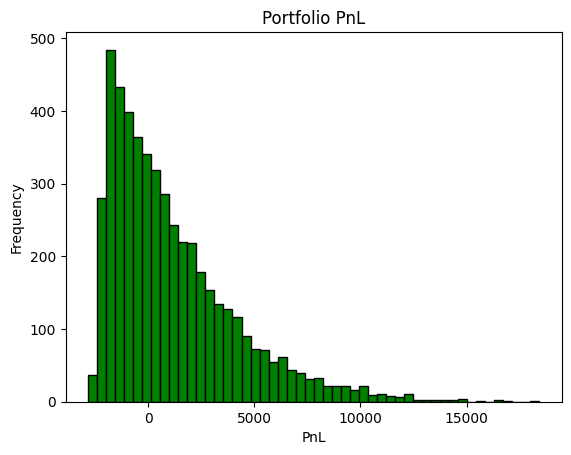

In [ ]:
##RISK MEASUREMENT/MANAGEMENT

## First of all we see what would happen to our portfolio with the simulations scenarios we have generated
#We compute the portfolio value for each simulation, getting a distribution for it, and then we figure out its VaR

Total_Simulation_Prices = np.concatenate((Simulated_call_option_prices, Simulated_put_option_prices,
                                          Simulated_OTC_call_prices, Simulated_OTC_put_prices, np.expand_dims(Simulated_stock_prices, axis = 1)), axis = 1)

Value_Portfolio_simulations = np.sum(Total_Simulation_Prices*FINAL_N_contracts, axis = 1)
PnL = Value_Portfolio_simulations - FINAL_amount
VaR_95 = np.percentile(PnL, 5)
print("The VaR95 is: ", VaR_95)

Expected_PnL = np.mean(PnL)
print("The Expected PnL is: ", Expected_PnL)

plt.figure()
plt.hist(PnL, bins = 50, color = 'green', edgecolor = 'black')
plt.title('Portfolio PnL')
plt.xlabel('PnL')
plt.ylabel('Frequency')
plt.show()

In [ ]:
##SENSITIVITIES ANALYSIS - Six scenarios for each option
Call_sensitivity_matrix = np.zeros((np.size(Call_option_prices, 0), 6))
Put_sensitivity_matrix = np.zeros((np.size(Put_option_prices, 0), 6))
OTC_Call_sensitivity_matrix = np.zeros((np.size(OTC_Call_data, 0), 6))
OTC_Put_sensitivity_matrix = np.zeros((np.size(OTC_Put_data, 0), 6))

#Listed Call options sentivities
for i in range(Call_sensitivity_matrix.shape[0]):
        #MKT +1%
        Call_sensitivity_matrix[i, 0] = black_scholes('call', S0*1.01, Call_option_prices['Strike'][i], (Call_option_prices['Time'][i]-5)/250, Call_option_prices['Interest Rates'][i], Call_option_prices['IV'][i])[0]
        #MKT +10%
        Call_sensitivity_matrix[i, 1] = black_scholes('call', S0*1.1, Call_option_prices['Strike'][i], (Call_option_prices['Time'][i]-5)/250, Call_option_prices['Interest Rates'][i], Call_option_prices['IV'][i])[0]
        #MKT -10%
        Call_sensitivity_matrix[i, 2] = black_scholes('call', S0*0.9, Call_option_prices['Strike'][i], (Call_option_prices['Time'][i]-5)/250, Call_option_prices['Interest Rates'][i], Call_option_prices['IV'][i])[0]
        #Vola +1%
        Call_sensitivity_matrix[i, 3] = black_scholes('call', S0, Call_option_prices['Strike'][i], (Call_option_prices['Time'][i]-5)/250, Call_option_prices['Interest Rates'][i], Call_option_prices['IV'][i]+0.01)[0]
        #Vola +20%
        Call_sensitivity_matrix[i, 4] = black_scholes('call', S0, Call_option_prices['Strike'][i], (Call_option_prices['Time'][i]-5)/250, Call_option_prices['Interest Rates'][i], Call_option_prices['IV'][i]+0.2)[0]
        #Vola -20%
        Call_sensitivity_matrix[i, 5] = black_scholes('call', S0, Call_option_prices['Strike'][i], (Call_option_prices['Time'][i]-5)/250, Call_option_prices['Interest Rates'][i], Call_option_prices['IV'][i]-0.2)[0]

#Listed Put options sensitivities

for i in range(Put_sensitivity_matrix.shape[0]):
    #MKT +1%
    Put_sensitivity_matrix[i, 0] = black_scholes('put', S0*1.01, Put_option_prices['Strike'][i], (Put_option_prices['Time'][i]-5)/250, Put_option_prices['Interest Rates'][i], Put_option_prices['IV'][i])[0]
    #MKT +10%
    Put_sensitivity_matrix[i, 1] = black_scholes('put', S0*1.1, Put_option_prices['Strike'][i], (Put_option_prices['Time'][i]-5)/250, Put_option_prices['Interest Rates'][i], Put_option_prices['IV'][i])[0]
    #MKT -10%
    Put_sensitivity_matrix[i, 2] = black_scholes('put', S0*0.9, Put_option_prices['Strike'][i], (Put_option_prices['Time'][i]-5)/250, Put_option_prices['Interest Rates'][i], Put_option_prices['IV'][i])[0]
    #Vola +1%
    Put_sensitivity_matrix[i, 3] = black_scholes('put', S0, Put_option_prices['Strike'][i], (Put_option_prices['Time'][i]-5)/250, Put_option_prices['Interest Rates'][i], Put_option_prices['IV'][i]+0.01)[0]
    #Vola +20%
    Put_sensitivity_matrix[i, 4] = black_scholes('put', S0, Put_option_prices['Strike'][i], (Put_option_prices['Time'][i]-5)/250, Put_option_prices['Interest Rates'][i], Put_option_prices['IV'][i]+0.2)[0]
    #Vola -20%
    Put_sensitivity_matrix[i, 5] = black_scholes('put', S0, Put_option_prices['Strike'][i], (Put_option_prices['Time'][i]-5)/250, Put_option_prices['Interest Rates'][i], Put_option_prices['IV'][i]-0.2)[0]

#OTC Call options sensitivities

for i in range(OTC_Call_data.shape[0]):
    #MKT +1%
    OTC_Call_sensitivity_matrix[i, 0] = black_scholes('call', S0*1.01, OTC_Call_data['Strike'][i], (OTC_Call_data['Time'][i]-5)/250, OTC_Call_data['Interest Rates'][i], OTC_Call_data['IV'][i])[0]
    #MKT +10%
    OTC_Call_sensitivity_matrix[i, 1] = black_scholes('call', S0*1.1, OTC_Call_data['Strike'][i], (OTC_Call_data['Time'][i]-5)/250, OTC_Call_data['Interest Rates'][i], OTC_Call_data['IV'][i])[0]
    #MKT -10%
    OTC_Call_sensitivity_matrix[i, 2] = black_scholes('call', S0*0.9, OTC_Call_data['Strike'][i], (OTC_Call_data['Time'][i]-5)/250, OTC_Call_data['Interest Rates'][i], OTC_Call_data['IV'][i])[0]
    #Vola +1%
    OTC_Call_sensitivity_matrix[i, 3] = black_scholes('call', S0, OTC_Call_data['Strike'][i], (OTC_Call_data['Time'][i]-5)/250, OTC_Call_data['Interest Rates'][i], OTC_Call_data['IV'][i]+0.01)[0]
    #Vola +20%
    OTC_Call_sensitivity_matrix[i, 4] = black_scholes('call', S0, OTC_Call_data['Strike'][i], (OTC_Call_data['Time'][i]-5)/250, OTC_Call_data['Interest Rates'][i], OTC_Call_data['IV'][i]+0.2)[0]
    #Vola -20%
    OTC_Call_sensitivity_matrix[i, 5] = black_scholes('call', S0, OTC_Call_data['Strike'][i], (OTC_Call_data['Time'][i]-5)/250, OTC_Call_data['Interest Rates'][i], OTC_Call_data['IV'][i]-0.2)[0]

#OTC Put options sensitivities

for i in range(OTC_Put_data.shape[0]):
    #MKT +1%
    OTC_Put_sensitivity_matrix[i, 0] = black_scholes('put', S0*1.01, OTC_Put_data['Strike'][i], (OTC_Put_data['Time'][i]-5)/250, OTC_Put_data['Interest Rates'][i], OTC_Put_data['IV'][i])[0]
    #MKT +10%
    OTC_Put_sensitivity_matrix[i, 1] = black_scholes('put', S0*1.1, OTC_Put_data['Strike'][i], (OTC_Put_data['Time'][i]-5)/250, OTC_Put_data['Interest Rates'][i], OTC_Put_data['IV'][i])[0]
    #MKT -10%
    OTC_Put_sensitivity_matrix[i, 2] = black_scholes('put', S0*0.9, OTC_Put_data['Strike'][i], (OTC_Put_data['Time'][i]-5)/250, OTC_Put_data['Interest Rates'][i], OTC_Put_data['IV'][i])[0]
    #Vola +1%
    OTC_Put_sensitivity_matrix[i, 3] = black_scholes('put', S0, OTC_Put_data['Strike'][i], (OTC_Put_data['Time'][i]-5)/250, OTC_Put_data['Interest Rates'][i], OTC_Put_data['IV'][i]+0.01)[0]
    #Vola +20%
    OTC_Put_sensitivity_matrix[i, 4] = black_scholes('put', S0, OTC_Put_data['Strike'][i], (OTC_Put_data['Time'][i]-5)/250, OTC_Put_data['Interest Rates'][i], OTC_Put_data['IV'][i]+0.2)[0]
    #Vola -20%
    OTC_Put_sensitivity_matrix[i, 5] = black_scholes('put', S0, OTC_Put_data['Strike'][i], (OTC_Put_data['Time'][i]-5)/250, OTC_Put_data['Interest Rates'][i], OTC_Put_data['IV'][i]-0.2)[0]


#We wanna store the whole sensitivities in a dataframe

Stock_sensitivity = np.array([S0*1.01, S0*1.1, S0*0.9, S0, S0, S0]).reshape(1, -1)
Total_sensitivity_matrix = np.concatenate((Call_sensitivity_matrix, Put_sensitivity_matrix, OTC_Call_sensitivity_matrix, OTC_Put_sensitivity_matrix, Stock_sensitivity), axis = 0)
Total_sensitivity_matrix = pd.DataFrame(Total_sensitivity_matrix, columns = ['MKT +1%', 'MKT +10%', 'MKT -10%', 'Vola +1%', 'Vola +20%', 'Vola -20%'])

#We compute the PnL sensitivity of our portfolio for each of the six scenarios

PnL_sensitivities = np.sum(Total_sensitivity_matrix.T*FINAL_N_contracts, axis = 1) - FINAL_amount
PnL_sensitivities_df = pd.DataFrame(PnL_sensitivities, columns = ['PnL'])
print(PnL_sensitivities_df)

                   PnL
MKT +1%     792.904872
MKT +10%   9828.579430
MKT -10%  -1621.935779
Vola +1%    196.968277
Vola +20%   112.202851
Vola -20% -2720.250186


In [ ]:
#MARKET GRANULAR LIMITS - based on risk factor sensitivities of the strategy which corresponds to VaR = 10k
Market_Granular_Limits = np.array([1000, -15000, -15000, 3000, -5000, -5000])
Market_Granular_Limits_df = pd.DataFrame(Market_Granular_Limits, index = ['MKT +1%', 'MKT +10%', 'MKT -10%', 'Vola +1%', 'Vola +20%', 'Vola -20%'], columns = ['Market Granular Limits'])

#We have to compare our PnL sensitivities with the Market Granular Limits, once by once

if abs(PnL_sensitivities[0]) > Market_Granular_Limits[0]:
    print("WARNING: The strategy is not compliant with the Mkt +1% Market Granular Limits")
else:
    print("The strategy is compliant with the Mkt +1% Market Granular Limits")

if PnL_sensitivities[1] < Market_Granular_Limits[1]:
    print("WARNING: The strategy is not compliant with the Mkt +10% Market Granular Limits")
else:
    print("The strategy is compliant with the Mkt +10% Market Granular Limits")

if PnL_sensitivities[2] < Market_Granular_Limits[2]:
    print("WARNING: The strategy is not compliant with the Mkt -10% Market Granular Limits")
else:
    print("The strategy is compliant with the Mkt -10% Market Granular Limits")

if abs(PnL_sensitivities[3]) > Market_Granular_Limits[3]:
    print("WARNING: The strategy is not compliant with the Vola +1% Market Granular Limits")
else:
    print("The strategy is compliant with the Vola +1% Market Granular Limits")

if PnL_sensitivities[4] < Market_Granular_Limits[4]:
    print("WARNING: The strategy is not compliant with the Vola +20% Market Granular Limits")
else:
    print("The strategy is compliant with the Vola +20% Market Granular Limits")

if PnL_sensitivities[5] < Market_Granular_Limits[5]:
    print("WARNING: The strategy is not compliant with the Vola -20% Market Granular Limits")
else:
    print("The strategy is compliant with the Vola -20% Market Granular Limits")


Limit_Usage = PnL_sensitivities/Market_Granular_Limits

#We want to compute the Gross Sensitivity Long and the Gross Sensitivity Short, whose sum gives the Net PnL Sensitivity
Long_Contracts = np.zeros(np.size(FINAL_N_contracts))
Short_Contracts = np.zeros(np.size(FINAL_N_contracts))

for i in range(np.size(FINAL_N_contracts)):
    if FINAL_N_contracts[i] > 0:
        Long_Contracts[i] = FINAL_N_contracts[i]
    else:
        Short_Contracts[i] = FINAL_N_contracts[i]

Long_Final_Amount = (Long_Contracts*np.concatenate((TOTAL_Options['Price'], [S0]))).sum()
Short_Final_Amount = (Short_Contracts*np.concatenate((TOTAL_Options['Price'], [S0]))).sum()
Gross_Sensitivity_Long = np.sum(Total_sensitivity_matrix.T*Long_Contracts, axis = 1) - Long_Final_Amount
Gross_Sensitivity_Short = np.sum(Total_sensitivity_matrix.T*Short_Contracts, axis = 1) - Short_Final_Amount

Specific_Sensitivity_df = pd.DataFrame({'Total PnL Sensitivity': PnL_sensitivities, 'Gross Sensitivity Long': Gross_Sensitivity_Long, 'Gross Sensitivity Short': Gross_Sensitivity_Short})
print(Specific_Sensitivity_df)

The strategy is compliant with the Mkt +1% Market Granular Limits
The strategy is compliant with the Mkt +10% Market Granular Limits
The strategy is compliant with the Mkt -10% Market Granular Limits
The strategy is compliant with the Vola +1% Market Granular Limits
The strategy is compliant with the Vola +20% Market Granular Limits
The strategy is compliant with the Vola -20% Market Granular Limits
           Total PnL Sensitivity  Gross Sensitivity Long  \
MKT +1%               792.904872            10312.317986   
MKT +10%             9828.579430            38291.072487   
MKT -10%            -1621.935779             -580.533766   
Vola +1%              196.968277            10567.942964   
Vola +20%             112.202851            55427.540663   
Vola -20%           -2720.250186           -38706.059488   

           Gross Sensitivity Short  
MKT +1%               -9519.413114  
MKT +10%             -28462.493057  
MKT -10%              -1041.402013  
Vola +1%             -10370.

<ipython-input-15-a239555e85e4>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(PnL_sensitivities[0]) > Market_Granular_Limits[0]:
<ipython-input-15-a239555e85e4>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if PnL_sensitivities[1] < Market_Granular_Limits[1]:
<ipython-input-15-a239555e85e4>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if PnL_sensitivities[2] < Market_Granular_Limits[2]:
<ipython-input-15-a239555e8

In [ ]:
##STRESS SCENARIOS
#We define four stress scenarios
Stress_scenarios = np.array([[-0.15, 0.70, -0.015, 0], [0.25, -0.30, 0, 0], [0.30, -0.25, -0.005, 0], [-0.30, 0.20, -0.005, 0]])
Stress_scenarios_df = pd.DataFrame(Stress_scenarios, columns = ['Stock Price Stress', 'Volatility Stress', 'Interest Rate Stress', 'PnL Reaction'], index = ['Covid_19', 'Rally Tech (Nov21)', 'Outstanding Earnings Release', 'Disappointing Earnings Release'])

#We compute the PnL for each of the four scenarios
Call_stress_scenarios_matrix = np.zeros((np.size(Call_option_prices, 0), 4))
Put_stress_scenarios_matrix = np.zeros((np.size(Put_option_prices, 0), 4))
OTC_Call_stress_scenarios_matrix = np.zeros((np.size(OTC_Call_data, 0), 4))
OTC_Put_stress_scenarios_matrix = np.zeros((np.size(OTC_Put_data, 0), 4))

#Listed Call options sensitivities
for i in range(Call_stress_scenarios_matrix.shape[0]):
    for j in range(4):
        Call_stress_scenarios_matrix[i, j] = black_scholes('call', S0*(1+Stress_scenarios[j, 0]), Call_option_prices['Strike'][i], (Call_option_prices['Time'][i]-5)/250, Call_option_prices['Interest Rates'][i]+Stress_scenarios[j, 2], Call_option_prices['IV'][i]+Stress_scenarios[j, 1])[0]

#Listed Put options sensitivities
for i in range(Put_stress_scenarios_matrix.shape[0]):
    for j in range(4):
        Put_stress_scenarios_matrix[i, j] = black_scholes('put', S0*(1+Stress_scenarios[j, 0]), Put_option_prices['Strike'][i], (Put_option_prices['Time'][i]-5)/250, Put_option_prices['Interest Rates'][i]+Stress_scenarios[j, 2], Put_option_prices['IV'][i]+Stress_scenarios[j, 1])[0]

#OTC Call options sensitivities
for i in range(OTC_Call_data.shape[0]):
    for j in range(4):
        OTC_Call_stress_scenarios_matrix[i, j] = black_scholes('call', S0*(1+Stress_scenarios[j, 0]), OTC_Call_data['Strike'][i], (OTC_Call_data['Time'][i]-5)/250, OTC_Call_data['Interest Rates'][i]+Stress_scenarios[j, 2], OTC_Call_data['IV'][i]+Stress_scenarios[j, 1])[0]

#OTC Put options sensitivities
for i in range(OTC_Put_data.shape[0]):
    for j in range(4):
        OTC_Put_stress_scenarios_matrix[i, j] = black_scholes('put', S0*(1+Stress_scenarios[j, 0]), OTC_Put_data['Strike'][i], (OTC_Put_data['Time'][i]-5)/250, OTC_Put_data['Interest Rates'][i]+Stress_scenarios[j, 2], OTC_Put_data['IV'][i]+Stress_scenarios[j, 1])[0]


Stock_stress_sensitivity = np.array([S0*(1+Stress_scenarios[j, 0]) for j in range(4)]).reshape(1, -1)
Total_stress_sensitivity_matrix = np.concatenate((Call_stress_scenarios_matrix, Put_stress_scenarios_matrix, OTC_Call_stress_scenarios_matrix, OTC_Put_stress_scenarios_matrix, Stock_stress_sensitivity), axis = 0)
Total_stress_sensitivity_matrix = pd.DataFrame(Total_stress_sensitivity_matrix, columns = ['Covid_19', 'Rally Tech (Nov21)', 'Outstanding Earnings Release', 'Disappointing Earnings Release'])

#We want to test the sensitivity of our portfolio to the different scenarios
PnL_stress_scenarios = np.sum(Total_stress_sensitivity_matrix.T*FINAL_N_contracts, axis = 1) - FINAL_amount
Stress_scenarios_df['PnL Reaction'] = PnL_stress_scenarios
print(Stress_scenarios_df['PnL Reaction'])


##STRESS TEST WARMING LEVEL
#Select the worst scenario as Stress test warming level
Worst_scenario = Stress_scenarios_df['PnL Reaction'].idxmin()
Worst_scenario_value = Stress_scenarios_df['PnL Reaction'].min()
Stress_test_warming_level = pd.DataFrame({'Worst Scenario': [Worst_scenario], 'STWL': [Worst_scenario_value]})
print("The worst scenario is: ", Worst_scenario)
print("The worst scenario value is: ", Worst_scenario_value)

Covid_19                          -9271.183098
Rally Tech (Nov21)                36769.720008
Outstanding Earnings Release      46214.763730
Disappointing Earnings Release     1580.770409
Name: PnL Reaction, dtype: float64
The worst scenario is:  Covid_19
The worst scenario value is:  -9271.183097685047


In [ ]:
#FINAL PORTFOLIO COMPOSITION - HIGHLIGHTING THE NUMBER OF CONTRACTS
N_CALL_LISTED= FINAL_N_contracts_df[FINAL_N_contracts_df.index == 'Listed Call'][0].sum()
N_PUT_LISTED= FINAL_N_contracts_df[FINAL_N_contracts_df.index == 'Listed Put'][0].sum()
N_CALL_OTC= FINAL_N_contracts_df[FINAL_N_contracts_df.index == 'OTC Call'][0].sum()
N_PUT_OTC= FINAL_N_contracts_df[FINAL_N_contracts_df.index == 'OTC Put'][0].sum()
N_UNDERLYING= FINAL_N_contracts_df[FINAL_N_contracts_df.index == 'Underlying'][0].sum()
print("Number of Call Listed Options: ", N_CALL_LISTED)
print("Number of Put Listed Options: ", N_PUT_LISTED)
print("Number of Call OTC Options: ", N_CALL_OTC)
print("Number of Put OTC Options: ", N_PUT_OTC)
print("Number of Underlying Contracts: ", N_UNDERLYING)

Number of Call Listed Options:  -260.0
Number of Put Listed Options:  741.0
Number of Call OTC Options:  65.0
Number of Put OTC Options:  -310.0
Number of Underlying Contracts:  446.0


In [ ]:
#FINAL PORTFOLIO COMPOSITION IN DETAIL
N_listed_call_OTM = 0
N_listed_call_ITM = 0
N_listed_call_ATM = 0
for i in range(np.size(Call_option_prices, 0)):
    if Call_option_prices['Strike'].iloc[i]  < 710:
        N_listed_call_ITM += FINAL_N_contracts[i]
    elif Call_option_prices['Strike'].iloc[i]  > 715:
        N_listed_call_OTM += FINAL_N_contracts[i]
    else:
        N_listed_call_ATM += FINAL_N_contracts[i]

print("Number of Listed Call OTM: ", N_listed_call_OTM)
print("Number of Listed Call ITM: ", N_listed_call_ITM)
print("Number of Listed Call ATM: ", N_listed_call_ATM)

N_listed_put_OTM = 0
N_listed_put_ITM = 0
N_listed_put_ATM = 0
for i in range(np.size(Put_option_prices, 0)):
    if Put_option_prices['Strike'].iloc[i]  > 715:
        N_listed_put_ITM += FINAL_N_contracts[i+23]
    elif Put_option_prices['Strike'].iloc[i]  < 710:
        N_listed_put_OTM += FINAL_N_contracts[i+23]
    else:
        N_listed_put_ATM += FINAL_N_contracts[i+23]

print("Number of Listed Put OTM: ", N_listed_put_OTM)
print("Number of Listed Put ITM: ", N_listed_put_ITM)
print("Number of Listed Put ATM: ", N_listed_put_ATM)

N_OTC_call_OTM = 0
N_OTC_call_ITM = 0
N_OTC_call_ATM = 0
for i in range(np.size(OTC_Call_data, 0)):
    if OTC_Call_data['Strike'].iloc[i]  < 710:
        N_OTC_call_ITM += N_contracts_OTC[i]
    elif OTC_Call_data['Strike'].iloc[i]  > 715:
        N_OTC_call_OTM += N_contracts_OTC[i]
    else:
        N_OTC_call_ATM += N_contracts_OTC[i]

print("Number of OTC Call OTM: ", N_OTC_call_OTM)
print("Number of OTC Call ITM: ", N_OTC_call_ITM)
print("Number of OTC Call ATM: ", N_OTC_call_ATM)

N_OTC_put_OTM = 0
N_OTC_put_ITM = 0
N_OTC_put_ATM = 0
for i in range(np.size(OTC_Put_data, 0)):
    if OTC_Put_data['Strike'].iloc[i]  > 715:
        N_OTC_put_ITM += N_contracts_OTC[i+5]
    elif OTC_Put_data['Strike'].iloc[i] < 710:
        N_OTC_put_OTM += N_contracts_OTC[i+5]
    else:
        N_OTC_put_ATM += N_contracts_OTC[i+5]

print("Number of OTC Put OTM: ", N_OTC_put_OTM)
print("Number of OTC Put ITM: ", N_OTC_put_ITM)
print("Number of OTC Put ATM: ", N_OTC_put_ATM)

#ST
Options_Composition = pd.DataFrame({'Number of Listed Call OTM': [N_listed_call_OTM], 'Number of Listed Call ITM': [N_listed_call_ITM], 'Number of Listed Call ATM': [N_listed_call_ATM], 'Number of Listed Put OTM': [N_listed_put_OTM], 'Number of Listed Put ITM': [N_listed_put_ITM], 'Number of Listed Put ATM': [N_listed_put_ATM], 'Number of OTC Call OTM': [N_OTC_call_OTM], 'Number of OTC Call ITM': [N_OTC_call_ITM], 'Number of OTC Call ATM': [N_OTC_call_ATM], 'Number of OTC Put OTM': [N_OTC_put_OTM], 'Number of OTC Put ITM': [N_OTC_put_ITM], 'Number of OTC Put ATM': [N_OTC_put_ATM]}).T
Portfolio_Composition = pd.DataFrame({'Number of Call Listed Options': [N_CALL_LISTED], 'Number of Put Listed Options': [N_PUT_LISTED], 'Number of Call OTC Options': [N_CALL_OTC], 'Number of Put OTC Options': [N_PUT_OTC], 'Number of Underlying Contracts': [N_UNDERLYING]}).T

Number of Listed Call OTM:  156.0
Number of Listed Call ITM:  -175.0
Number of Listed Call ATM:  -241.0
Number of Listed Put OTM:  424.0
Number of Listed Put ITM:  -173.0
Number of Listed Put ATM:  490.0
Number of OTC Call OTM:  20
Number of OTC Call ITM:  35
Number of OTC Call ATM:  10
Number of OTC Put OTM:  -310
Number of OTC Put ITM:  0
Number of OTC Put ATM:  0


In [ ]:
### PLOTS

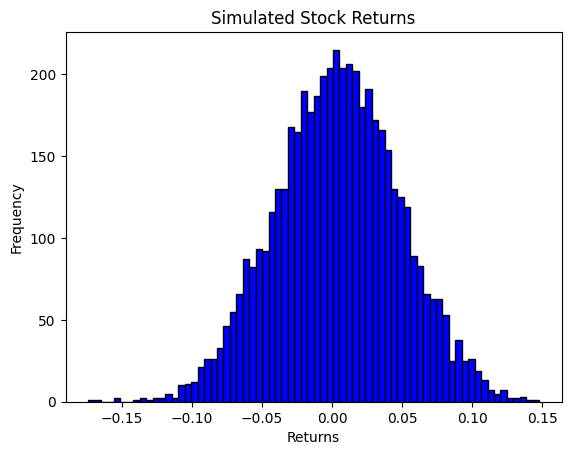

In [ ]:
#Plot of simulated stock returns
plt.figure()
plt.hist(Simulated_returns[0, :], bins = 70, color = 'blue', edgecolor = 'black')
plt.title('Simulated Stock Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

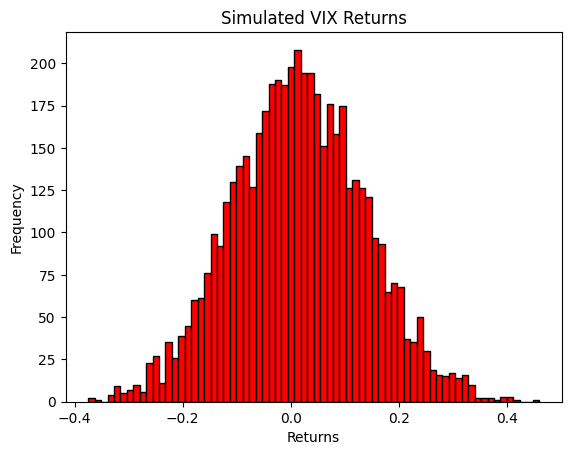

In [ ]:
#Plot of simulated VIX returns
plt.figure()
plt.hist(Simulated_returns[1, :], bins = 70, color = 'red', edgecolor = 'black')
plt.title('Simulated VIX Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

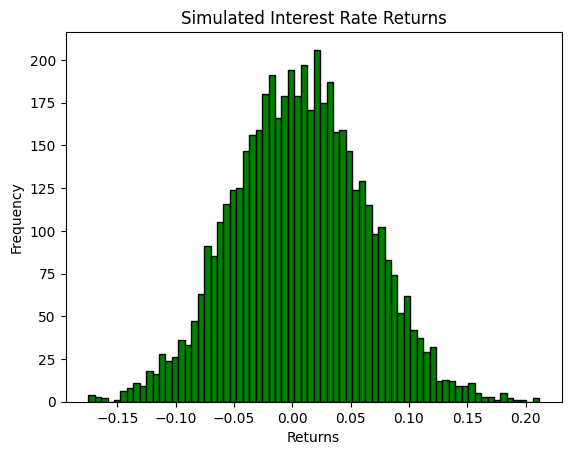

In [ ]:
#Plot of simulated interest rate returns
plt.figure()
plt.hist(Simulated_returns[2, :], bins = 70, color = 'green', edgecolor = 'black')
plt.title('Simulated Interest Rate Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

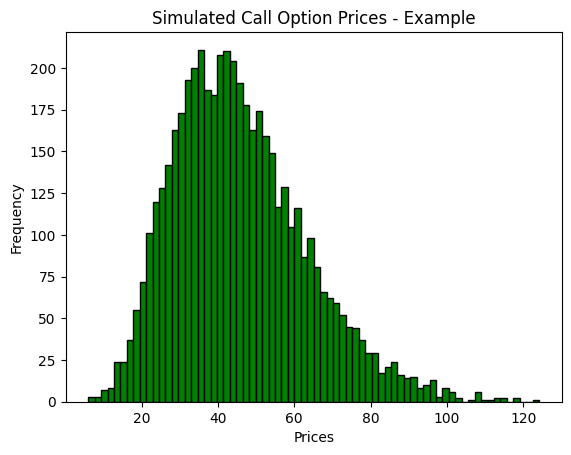

In [ ]:
#Plot of the simulated prices of the first listed call option - selected as an example
plt.figure()
plt.hist(Simulated_call_option_prices[:, 1], bins = 70, color = 'green', edgecolor = 'black')
plt.title('Simulated Call Option Prices - Example')
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.show()

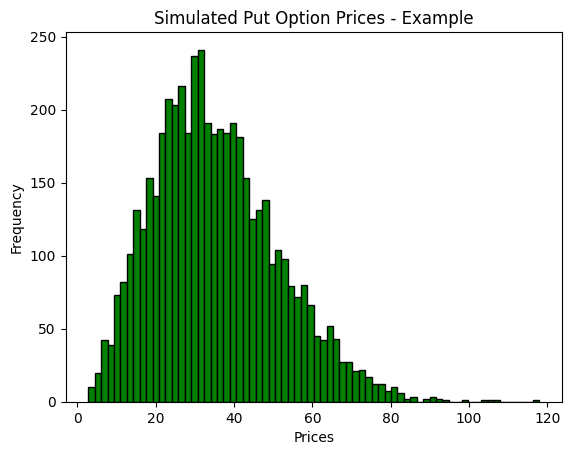

In [ ]:
#Plot of the simulated prices of the first listed put option - selected as an example
plt.figure()
plt.hist(Simulated_put_option_prices[:, 1], bins = 70, color = 'green', edgecolor = 'black')
plt.title('Simulated Put Option Prices - Example')
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.show()

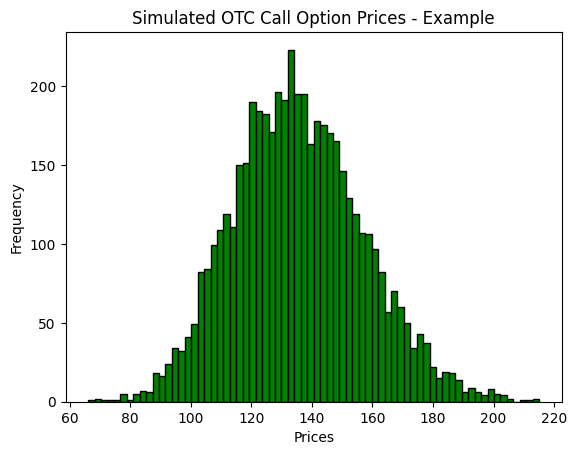

In [ ]:
#Plot of the simulated prices of the first OTC call option - selected as an example
plt.figure()
plt.hist(Simulated_OTC_call_prices[:, 1], bins = 70, color = 'green', edgecolor = 'black')
plt.title('Simulated OTC Call Option Prices - Example')
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.show()

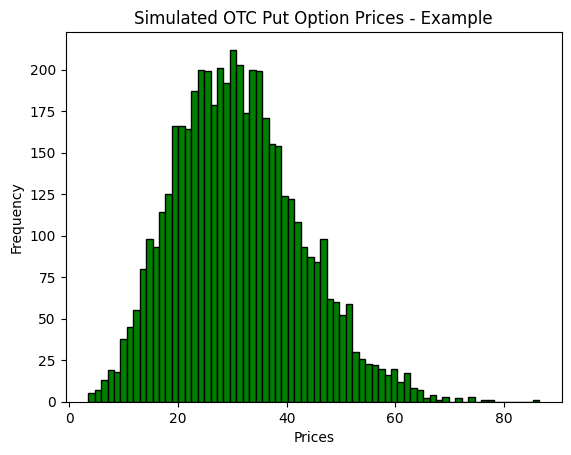

In [ ]:
#Plot of the simulated prices of the first OTC put option - selected as an example
plt.figure()
plt.hist(Simulated_OTC_put_prices[:, 1], bins = 70, color = 'green', edgecolor = 'black')
plt.title('Simulated OTC Put Option Prices - Example')
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.show()

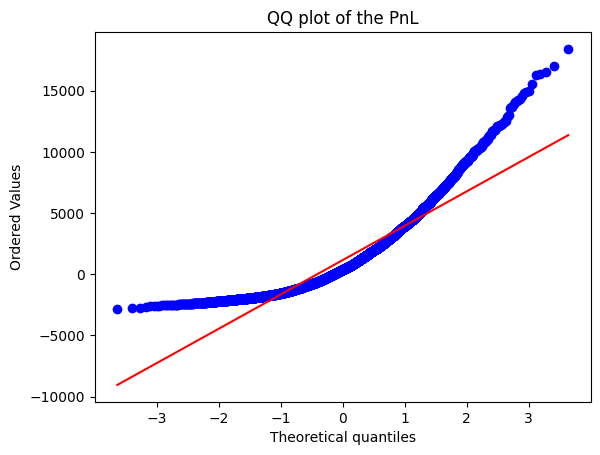

In [ ]:
#QQ plot of the PnL
stats.probplot(PnL, dist = 'norm', plot = plt)
plt.title('QQ plot of the PnL')
plt.show()

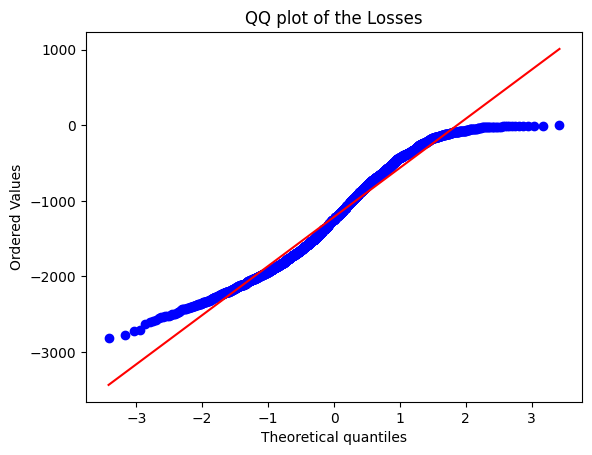

In [ ]:
##QQPlot of Losses only
Losses = PnL[PnL<0]
stats.probplot(Losses, dist = 'norm', plot = plt)
plt.title('QQ plot of the Losses')
plt.show()

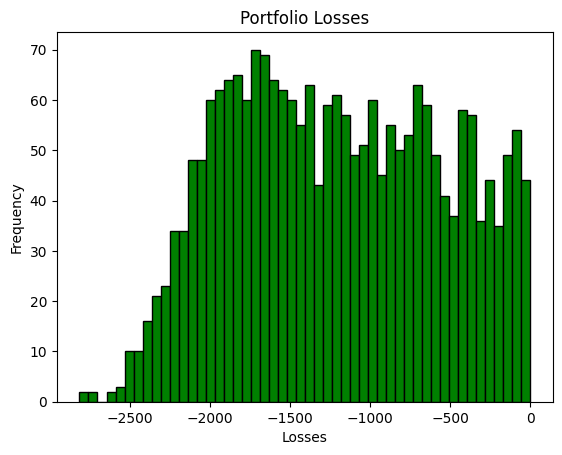

In [ ]:
#Distribution of Losses only
plt.figure()
plt.hist(Losses, bins = 50, color = 'green', edgecolor = 'black')
plt.title('Portfolio Losses')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()